# 신경망 모델 훈련

케라스 API를 사용해 모델을 훈련하는데 필요한 다양한 도구들을 아라보자.

## 손실 곡선

fit()메서드를 print하면 History 클래스 객체를 반환한다. 여기에는 훈련 과정에서 계사한 손실과 정화도 값이 저장되어 있다. 한 번 이 값으로 그래프를 그려보자.

### 데이터 준비

In [15]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

### 모델 만들기

In [16]:
### a_layer 매개변수로 케라스 층을 추가할 수 있다.
def model_fn(a_layer=None):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28,28)))
  model.add(keras.layers.Dense(100, activation='relu'))
  if a_layer: # 매개변수 None이면 밀집층과 출력층으로 구성
    model.add(a_layer)
  model.add(keras.layers.Dense(10, activation='softmax'))
  return model


In [17]:
model = model_fn()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               78500     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [18]:
# fit() 결과를 history 변수에 담기
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose=0) # verbose는 훈련 과정 출력을 조절한다. 0을 훈련과정을 나타내지 않음. 기본값은 1.

In [19]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


손실과 정확도가 history객체에 포함되어 있는 것을 볼 수 있다.

### 손실, 정확도 그래프로 그리기

케라스는 기본적으로 에포크마다 손실을 계산한다. 정확도는 compile에서 metrics 매개변수에 accuracy를 추가했기 때문에 history에 포함되었다.

참고로 인공 신경망 모델이 최적화 하는 대상은 정확도가 아니라 **손실함수**이다. 그렇기 때문에 손실 감소에 비례하여 정확도가 높아지지 않는 경우가 있다. 따라서 모델이 잘 훈련되었는지 확인하려면 정확도보다는 손실 함수의 값을 확인하는 것이 더 낫다.

여기의 손실과 정확도는 에포크마다 계산한 값이 순서대로 나열된 단순한 리스트이다. 이를 그래프로 그려보자.

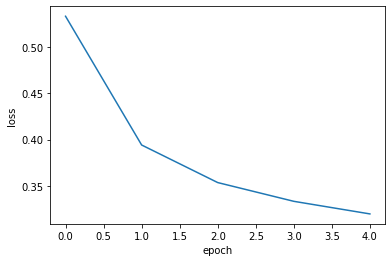

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss']) # 손실 그래프
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

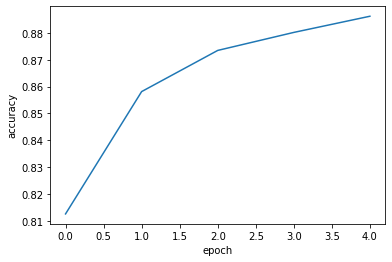

In [22]:
plt.plot(history.history['accuracy']) # 정확도 그래프
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

에포크마다 손실이 감소하고 정확도는 향상하고 있다.

에포크를 늘려서 모델을 훈련하고 그래프를 그려 보자.

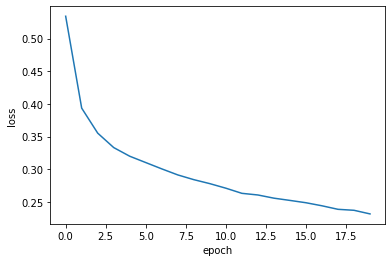

In [23]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

손실이 잘 감소하는 것을 볼 수 있다. 그런데 에포크를 무작정 늘리면 과대적합될 우려가 있었다. 

따라서 에포크에 따른 과대적합과 과소적합을 파악하려면 훈련 세트에 대한 점수뿐만 아니라 검증 세트에 대한 점수도 필요하다.

## 검증 손실

에포크마다 검증 손실을 계산하기 위해 fit에 검증데이터를 전달하수 있다.

In [24]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

In [25]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


val_loss는 검증세트에 대한 손실, 검증세트에 대한 정확도는 val_accuracy에 들어있을 것이다.

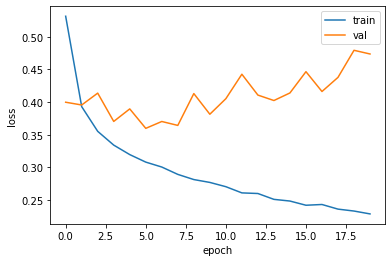

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

검증손실이 조금 감소하다가 다시 상승하기 시작한다. 검증 손실이 상승하는 시점(위에서는 7.5)을 최대한 뒤로 늦추면 검증 세트에 대한 손실이 줄어들 뿐만 아니라 검증 세트에 대한 정확도도 증가할 것이다. 

옵티마이저를 조정해 과대적합을 완화시켜보자.

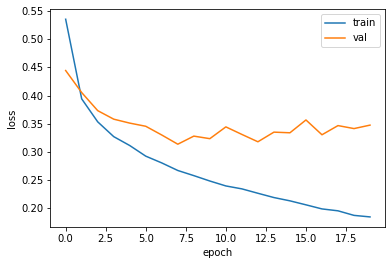

In [27]:
# Adam 옵티마이저 적용

model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 드롭아웃(dropout)

훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서(**뉴런의 출력을 0으로 만들어**) 과대적합을 막는 방법이다.

일부 뉴런이 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있고 모든 입력에 주의를 기울여야 한다. 인부 뉴런의 출력이 없을 수 있다는 것을 감안하면 이 신경망은 더 안정적인 예측을 만들 수 있다.

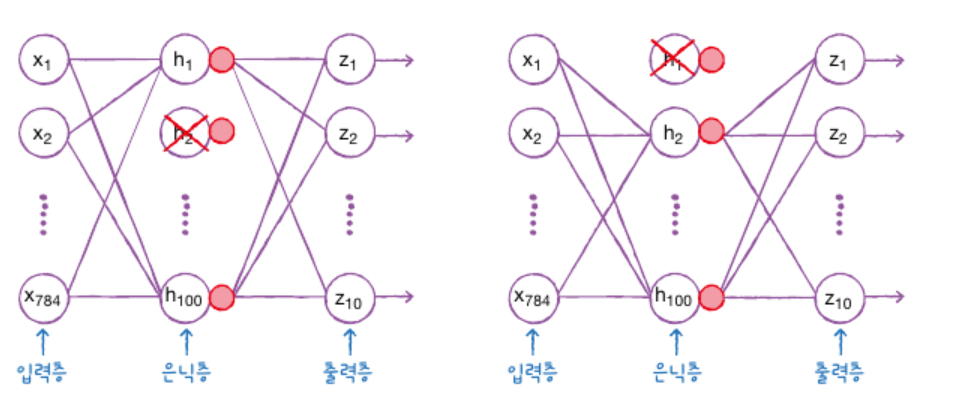

또 위의 오른쪽 그림처럼 2개의 신경망을 앙상블 하는 것과 같은 효과를 낼 수 있다.

케라스에서는 Dropout클래스를 제공하는데 어떤 층의 뒤에 드롭아웃을 두어 이 층의 출력을 랜덤하게 0으로 만들어리는 것이다. 

In [28]:
# 드롭아웃 객체로 층 추가.
model = model_fn(keras.layers.Dropout(0.3)) # 30% 정도 드롭아웃
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


훈련이 끝나고 **평가나 예측을 수행할 때는 드롭아웃을 적용하지 말아야 한다.**

텐서플로와 케라느는 평과 예측할 때 자동으로 드롭아웃을 적용하지 않는다.

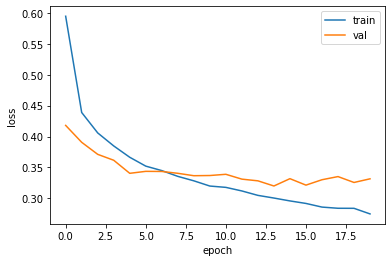

In [31]:
# 훈련 손실과 검증 손실의 그래프
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

과대적합이 줄었다. 하지만 역시 6부근에서 다소 과대적합되는 모습을 볼 수 있다. 그렇지만 책에서 나온 것처럼 에포크 횟수를 10으로 하고 다시 훈련해보자.

## 모델 저장과 복원



In [33]:
# 에포크 횟수 10으로 재훈련하기.
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=10, verbose=0, validation_data=(val_scaled, val_target))

케라스는 훈련된 모델의 파라미터를 저장하는 save_weights() 메서드를 제공한다.

기본적으로 텐서플로의 체크포인트 포맷으로 저장하지만 파일의 확장자가 '.h5'일 경우 HDF5 포맷으로 저장한다.

In [38]:
model.save_weights('model-weights.h5')

또 모델 구조와 모델 파라미터를 함께 저장하는 save() 메서드도 제공한다.

기본적으로 SavedModel 포맷으로 지정하지만 역시 확장자가'.h5'일 경우 HDF5 포맷으로 저장한다.

In [35]:
model.save('model-whole.h5')

In [36]:
!ls -al *.h5

-rw-r--r-- 1 root root 333448 Jul  1 00:18 'model=weights.h5'
-rw-r--r-- 1 root root 982664 Jul  1 00:20  model-whole.h5


### 파일에서 모델 파라미터 복원하여 훈련하기

In [39]:
model = model_fn(keras.layers.Dropout(0.3)) # 새 모델 만들기
model.load_weights('model-weights.h5') # 파라미터 불러오기 (저장했던 모델과 정확히 같은 구조를 가져야 함.)

이 모델의 검증 정확도를 확인해보자.

predict() 메서드는 샘플마다 10개의 클래스에 대한 확률을 반환한다. (다중 분류)

따라서 12,000개의 검증 세트가 있기 때문에 predict() 메서드는 (12000, 10) 크기의 배열을 반환한다.

따라서 정확도를 계산하기 위해선 10개의 열 중 가장 확률이 높은 열의 인덱스를 타깃과 비교하여야 한다.

In [41]:
import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis=-1) #가장 큰 값.
print(np.mean(val_labels == val_target))

0.09416666666666666


### 모델 전체를 불러오기

모델 파라미터, 모델 구조, 옵티마이자 상태까지 복원

In [43]:
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3245 - accuracy: 0.8813


[0.3244895935058594, 0.8812500238418579]

## 콜백

콜백은 훈련 과정 중간에 어떤 작업을 수할 수 있게 하는 객체이다.

fit() 메서드의 callbacks 매게변수에 리스트로 전달하여 사용한다.

여기서 사용할 ModelCheckpoint 콜백은 기본적으로 에포크마다 모델을 저장한다. 

save_best_only=True로 가장 낮은 검증 점수를 만드는 모델을 저장할 수 있다.


In [44]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb])

모델이 훈련한 후에 best-model.h5에 최상의 검증 점수를 낸 모델이 저장된다.

In [46]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3203 - accuracy: 0.8849


[0.32028138637542725, 0.8849166631698608]

.ModelCheckpoint 콜백이 가장 낮은 검증 점수의 모델을 자동으로 저장해주었다. 

하지만 역시 20번의 에포크를 수행했다. 검증 점수가 상승하면 그 이후에는 과대적합이 커져 훈련을 할 필요가 없다.

이때 훈련을 중지하면 컴퓨터 자원과 시간을 아낄 수 있다.
이를 **조기 종료**라 한다.

케라스에서는 조기 종료를 위한 EarlyStopping 콜백을 제공한다. 이 콜백의 patience 매개변수는 검증 점수가 향상되지 않더라도 참을 에포크 횟수로 지정한다. 

예를 들어 patience=2로 지정하면 2번 연속 검증 점수가 향상되지 않으면 훈련을 중지한다. 

In [47]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

In [48]:
print(early_stopping_cb.stopped_epoch) # 몇 번째 에포크에서 훈련이 중지 되었는지 출력

13


0부터 시작하기 때문에 14번째 에포크에서 훈련이 중지되었음을 의미한다. patience가 2이므로 14-2인 12번째 에포크가 최상의 모델일 것이다.

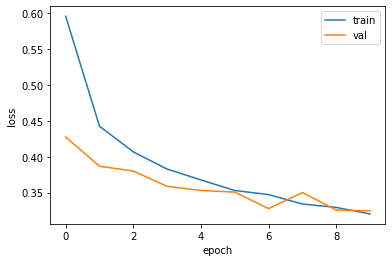

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [50]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3198 - accuracy: 0.8828


[0.31983482837677, 0.8828333616256714]